# Linear inverse solutions in NumPy

An exploration of seismic inversion — getting reflectivity from a seismic trce, given the wavelet.

We'll be working on a model, so we know the correct answer from the start.

Based on Mauricio Sacchi's [GEOPH 431 and 531 tutorial on linear inversion](https://www.ualberta.ca/~msacchi/GEOPH431_531/linear_intro.pdf), which was written in MATLAB. Mauricio's version is also recorded at SubSurfWiki on the [Linear inversion chrestomathy](http://www.subsurfwiki.org/wiki/Linear_inversion_chrestomathy) page.

**This notebook requires Python 3.5 and Numpy 1.11.**

First, the usual preliminaries.

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

Some of the regressors require sklearn 0.18.

In [2]:
import sklearn
sklearn.__version__

'0.18'

In [3]:
def norm(m):
    return m.T @ m

def misfit(d, d_pred):
    misfit = (d_pred - d).T @ (d_pred - d)
    return np.asscalar(misfit)

In [4]:
def plot_all(m, d, m_est, d_pred, equalize=True):
    """
    Helper function for plotting. You can ignore this.
    """
    fig = plt.figure(figsize=(10,6))

    ax0 = fig.add_subplot(2,2,1)
    ax0.plot(m)
    t = "$\mathrm{{Model}}\ m.\ \mathrm{{norm}}\ {:.3f}$"
    ax0.set_title(t.format(norm(m)))
    ax0_mi, ax0_ma = ax0.get_ylim()

    ax1 = fig.add_subplot(2,2,2)
    ax1.plot(d, 'o', mew=0)
    ax1.set_title("$\mathrm{Data}\ d$")
    ax1_mi, ax1_ma = ax1.get_ylim()

    ax2 = fig.add_subplot(2,2,3)
    ax2.plot(m, alpha=0.25)
    ax2.plot(m_est)
    t = "$\mathrm{{Estimated\ model}}\ m_\mathrm{{est}}.\ \mathrm{{norm}}\ {:.3f}$"
    ax2.set_title(t.format(norm(m_est)))
    ax2_mi, ax2_ma = ax2.get_ylim()

    ax3 = fig.add_subplot(2,2,4)
    ax3.plot(d, 'o', mew=0, alpha=0.25)
    ax3.plot(d_pred, 'o', mew=0)
    t = "$\mathrm{{Predicted\ data}}\ d_\mathrm{{pred}}.\ \mathrm{{misfit}}\ {:.3f}$"
    ax3.set_title(t.format(misfit(d, d_pred)))
    ax3_mi, ax3_ma = ax3.get_ylim()

    if equalize:
        ax0.set_ylim(min(ax0_mi, ax2_mi) - 0.5,
                     max(ax0_ma, ax2_ma) + 0.5)

        ax2.set_ylim(min(ax0_mi, ax2_mi) - 0.5,
                     max(ax0_ma, ax2_ma) + 0.5)

        ax1.set_ylim(min(ax1_mi, ax3_mi) - 0.5,
                     max(ax1_ma, ax3_ma) + 0.5)

        ax3.set_ylim(min(ax1_mi, ax3_mi) - 0.5,
                     max(ax1_ma, ax3_ma) + 0.5)

    plt.show()

In [5]:
from scipy import linalg as spla

def convmtx(h, n):
    """
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    """
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)

## Construct the model m

In [6]:
M = 50
m_ = np.zeros((M, 1))
m_[10:15,:] = 1.0
m_[15:27,:] = -0.3
m_[27:35,:] = 2.1

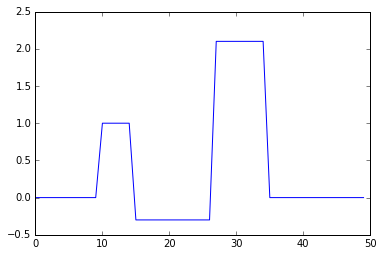

In [7]:
plt.plot(m_)

But I really want to use the reflectivity, so let's compute that:

In [8]:
ε = 1e-9  # Small float to avoid division by zero.
m = (m_[1:] - m_[:-1]) / (m_[1:] + m_[:-1] + ε)

We lose a sample when we do that, so add it back:

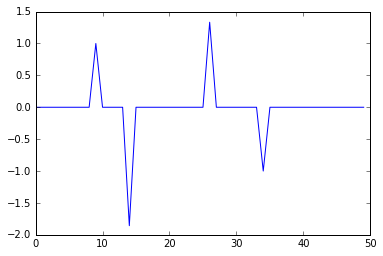

In [9]:
m = np.append(m, 0)

plt.plot(m)

## Forward operator: convolution with wavelet

Now we make the kernel matrix *G*, which represents convolution.

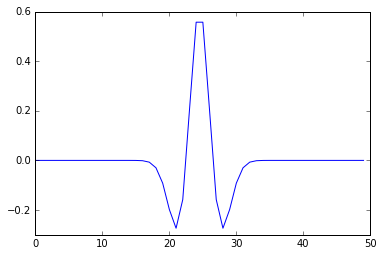

In [10]:
from scipy.signal import ricker
w_ = ricker(50, 2)

plt.plot(w_)

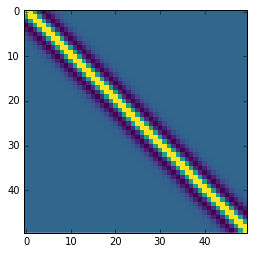

In [11]:
G = convmtx(w_, M)[:, 24:74]
plt.imshow(G, cmap='viridis', interpolation='none')

## Forward model the data d

Now we can perform the forward problem: computing the data.

In [12]:
d = G @ m

Let's visualize these components for fun...

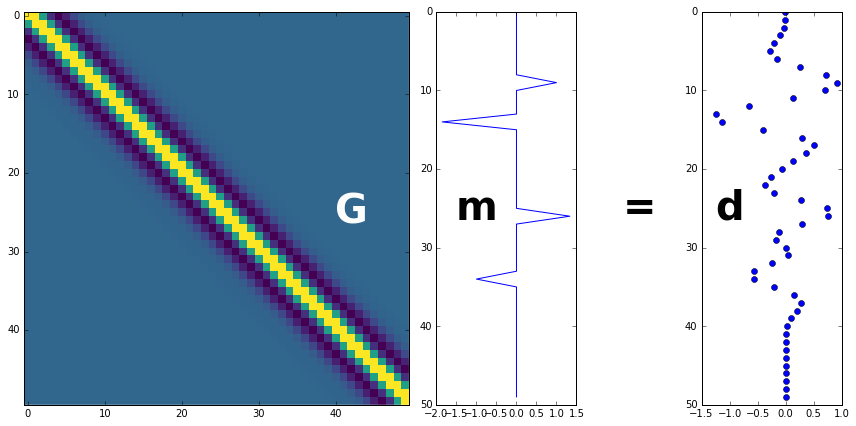

In [13]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 6))

gs = gridspec.GridSpec(1, 4, width_ratios=[5.5, 2, 1, 2]) 

params = {'ha': 'center', 
          'va': 'center',
          'size': 40,
          'weight': 'bold',
         }

ax0 = plt.subplot(gs[0])
_ = ax0.imshow(G, cmap='viridis', interpolation='none', aspect='auto')
ax0.text(42, 25, "G", color='w', **params)

y = np.arange(50)

ax1 = plt.subplot(gs[1])
ax1.plot(m, y)
ax1.text(-1, 25, "m", color='k', **params)
ax1.invert_yaxis()

ax2 = plt.subplot(gs[2])
ax2.set_frame_on(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.text(0.5, 0.5, "=", color='k', **params)

ax3 = plt.subplot(gs[3])
ax3.plot(d, y, 'o')
ax3.text(-1, 25, "d", color='k', **params)
ax3.invert_yaxis()

fig.tight_layout()
plt.show()

Now we can move on to the more interesting problem: if we only know a few measurements (i.e. this data `d`) and the kernel `G` that represents our understanding of the geophysics, can we _guess_ the model? 

## Noise-free: minimum norm

In [14]:
m_est = G.T @ la.inv(G @ G.T) @ d
d_pred = G @ m_est

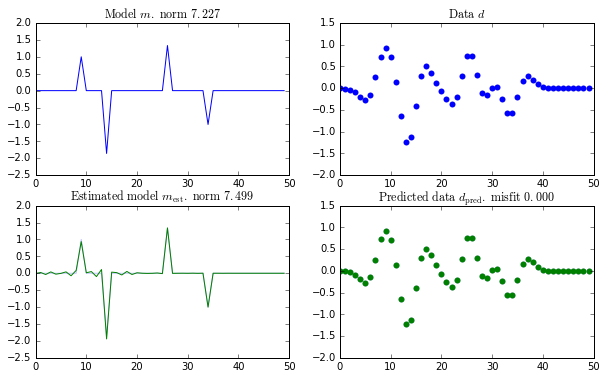

In [15]:
plot_all(m, d, m_est, d_pred)

## Solve with least squares

Not sure this is really the same as minimum norm.

In [16]:
m_est = la.lstsq(G, d)[0]
d_pred = G @ m_est

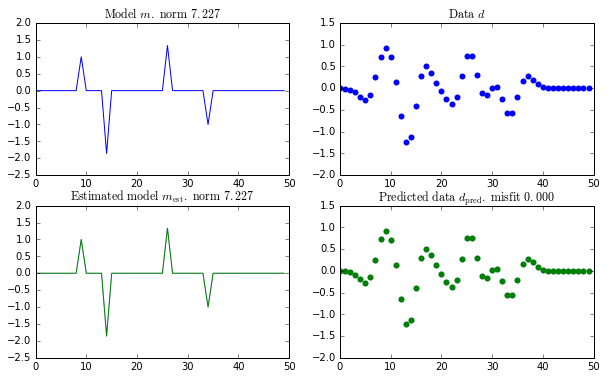

In [17]:
plot_all(m, d, m_est, d_pred)

## With noise: minimum weighted norm, or damped least squares

First, add noise:

In [18]:
s = 0.5
d += s * (np.random.random(d.shape) - 0.5)

Now the minimum norm doesn't work so well:

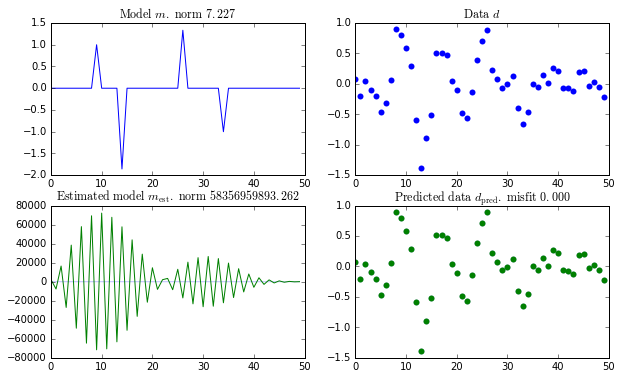

In [19]:
m_est = G.T @ la.inv(G @ G.T) @ d
d_pred = G @ m_est

plot_all(m, d, m_est, d_pred, equalize=False)

Now use Mauricio's second form:

In [20]:
I = np.eye(G.shape[0])
µ = 2.5  # We can use Unicode symbols in Python 3, just be careful
m_est = G.T @ la.inv(G @ G.T + µ * I) @ d
d_pred = G @ m_est

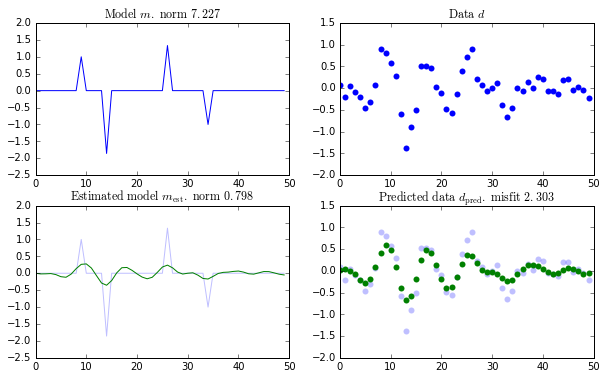

In [21]:
plot_all(m, d, m_est, d_pred)

## Minimum weighted norm with first derivative regularization

In [22]:
W = convmtx([1, -1], M)[:, :-1]  # Skip last column

Now we solve:

$$ \hat{\mathbf{m}} = (\mathbf{G}^\mathrm{T} \mathbf{G} + \mu \mathbf{W}^\mathrm{T} \mathbf{W})^{-1} \mathbf{G}^\mathrm{T} \mathbf{d} \ \ $$

In [23]:
m_est = la.inv(G.T @ G + µ * W.T @ W) @ G.T @ d
d_pred = G @ m_est

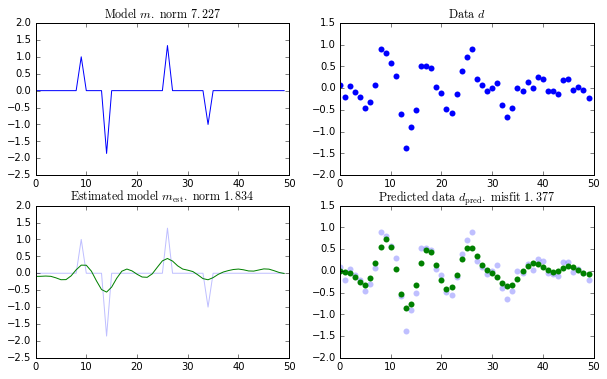

In [24]:
plot_all(m, d, m_est, d_pred)

## Minimum weighted norm with second derivative regularization

In [25]:
W = convmtx([1, -2, 1], M)[:, 1:-1]  # Skip first and last columns.

In [26]:
Q = la.inv(W @ W.T)

In [27]:
m_est = Q @ G.T @ la.inv(G @ Q @ G.T) @ d
d_pred = G @ m_est

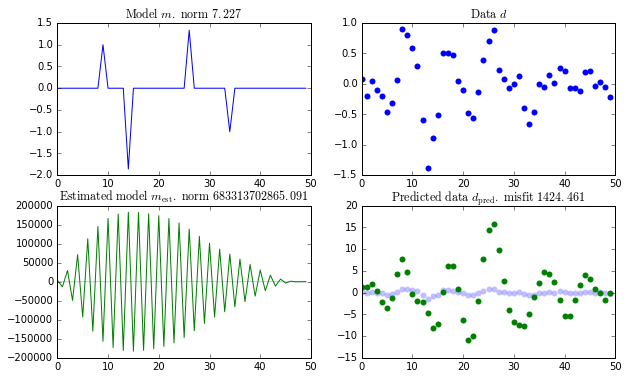

In [28]:
plot_all(m, d, m_est, d_pred, equalize=False)

## Minimum norm without inverting G

We can use other solvers, like `np.linalg.solve`, or `scipy.linalg.lu_solve`, but in the presence of noise they all give the same wrong answer.

### linalg.solve

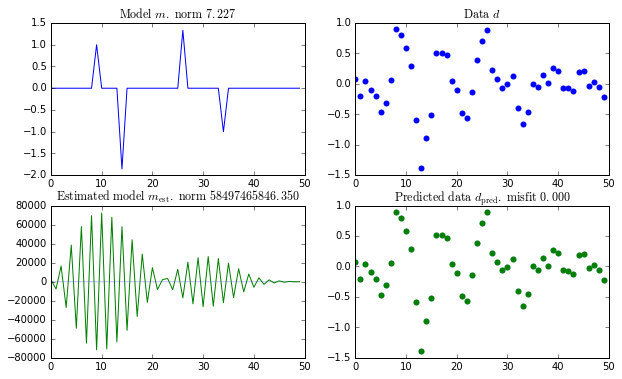

In [29]:
m_est = la.solve(G, d)
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred, equalize=False)

### QR factorization

In [30]:
q, r = la.qr(G)

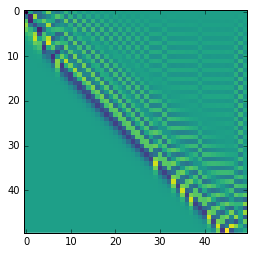

In [31]:
plt.imshow(q, cmap='viridis', interpolation='none')

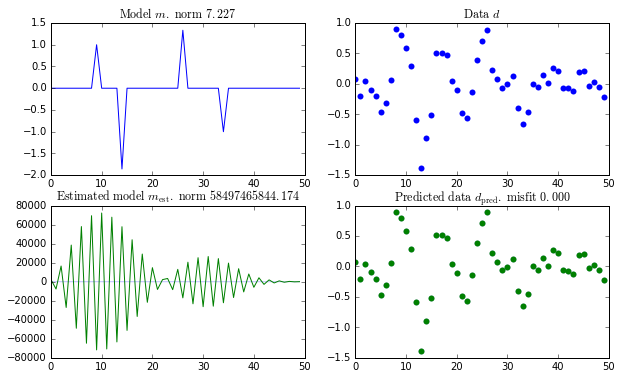

In [32]:
p = q.T @ d
m_est = la.inv(r) @ p
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred, equalize=False)

### LU factorization

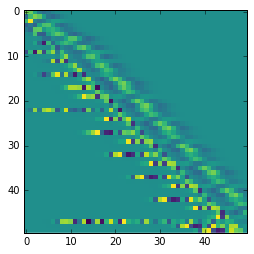

In [33]:
lu, piv = spla.lu_factor(G)
plt.imshow(lu, cmap='viridis', interpolation='none')

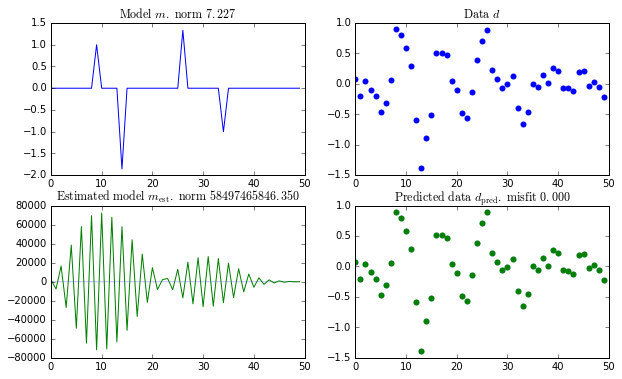

In [34]:
m_est = spla.lu_solve((lu, piv), d)
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred, equalize=False)

## Scikit Learn

Scikit-Learn is a machine learning package that has a large number of linear models, to do different kinds of regression with regularization. These will perform much better in the face of noise.

In [35]:
from sklearn import linear_model

### Ridge regression

Linear Model trained with L2 regularization.

[sklearn.linear_model.Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

Also known as [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization). 

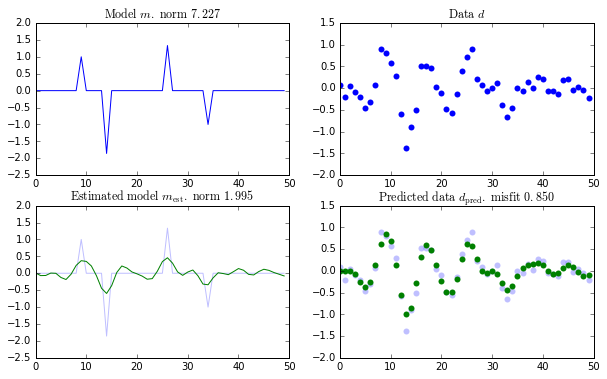

In [ ]:
reg = linear_model.Ridge(alpha=0.5, fit_intercept=False)
reg.fit(G, d)
m_est = reg.coef_
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred)

### Lasso

[The docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

Linear Model trained with L1 prior as regularizer (aka the Lasso).

For reasons I don't understand, I cannot get the ordinary `Lasso` mode to fit.

In [ ]:
reg = linear_model.LassoCV(fit_intercept=False)
reg.fit(G, d)
m_est = reg.coef_
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred, equalize=False)

/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Orthogonal matching pursuit

[The docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuit.html#sklearn.linear_model.OrthogonalMatchingPursuit)

Seems like a sort of sparse spike inversion.

Can provide number of spikes, or tolerance. Try setting `tol=1` hyperparameter.

In [ ]:
reg = linear_model.OrthogonalMatchingPursuit(fit_intercept=False)
reg.fit(G, d)
m_est = reg.coef_
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred)